# Tema 7: Grover

Curso ICC02.

Autor: Alejandro Mata Ali

En este notebook vamos a implementar el algoritmo de Grover para diferentes oráculos.

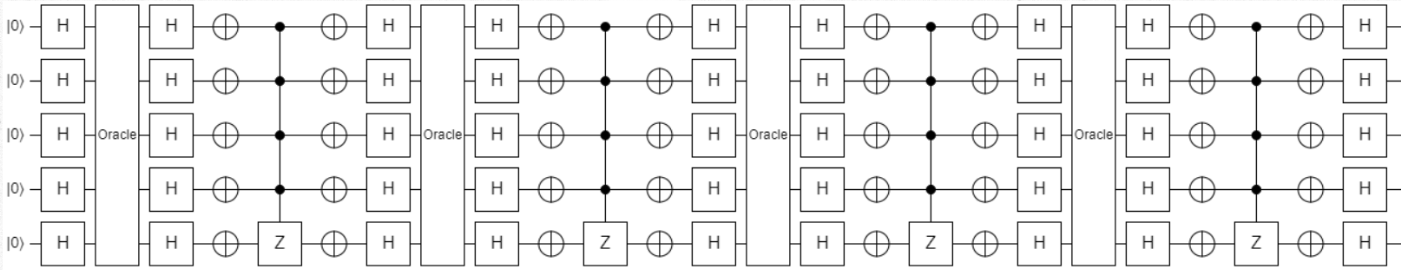

## Librerías

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import MCMT, ZGate
import numpy as np

---
# Circuito cuántico

Para el circuito cuántico tendremos que tener n qubits. Vamos a definirlo ya de forma abstracta con una función que reciba el número n y el oráculo como una instrucción.

In [2]:
def Grover_Circuit(n:int, oracle):
    #Registros
    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(n, 'c')

    #Circuito
    qc = QuantumCircuit(qr, cr, name='Grover')

    #Capa de H
    qc.h(range(n))
    qc.barrier()

    n_reps = int(np.pi/4*np.sqrt(2**n))
    #Control-Z con varios ctrl
    multicontrolz = MCMT(ZGate(), n-1, 1)
    for i in range(n_reps):
        #Oraculo
        qc.append(oracle, range(n))
        qc.barrier()

        #Difusor
        qc.h(range(n))
        qc.x(range(n))
        qc.append(multicontrolz, range(n))
        qc.x(range(n))
        qc.h(range(n))
        qc.barrier()

    #Mediciones
    qc.measure(range(n), range(n))

    decomp_qc = qc.decompose(['mcmt', 'Oracle'], reps=2)

    return decomp_qc

### Ejercicio

Prueba a hacer la misma función, pero usando el repeat.

In [ ]:
def Grover_Circuit(n:int, oracle):
    #Registros
    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(n, 'c')

    #Circuito
    qc = QuantumCircuit(qr, cr, name='Grover')

    #Capa de H
    qc.h(range(n))
    qc.barrier()

    n_reps = int(np.pi/4*np.sqrt(2**n))
    #Control-Z con varios ctrl
    multicontrolz = MCMT(ZGate(), n-1, 1)
    def repetition_step(n:int, oracle):
        qc = QuantumCircuit(3, name='Repetition')
        #Oraculo
        qc.append(oracle, range(n))
        qc.barrier()

        #Difusor
        qc.h(range(n))
        qc.x(range(n))
        qc.append(multicontrolz, range(n))
        qc.x(range(n))
        qc.h(range(n))
        qc.barrier()

        return qc

    qc.append(repetition_step(n, oracle).repeat(n_reps), range(n))

    #Mediciones
    qc.measure(range(n), range(n))

    decomp_qc = qc.decompose(['mcmt', 'Oracle',"Repetition**2",'Repetition'], reps=3)

    return decomp_qc

## Oráculo

Ahora definamos un oráculo para introducir.  Vamos a probar uno que marque el estado 100.

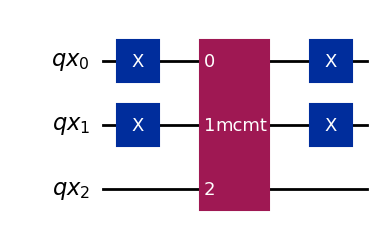

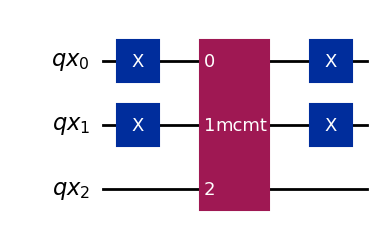

In [3]:
n = 3

#Registros
qr_x = QuantumRegister(n, 'qx')

oracle = QuantumCircuit(qr_x, name='Oracle')

#Puertas
multicontrolz = MCMT(ZGate(), n-1, 1)
oracle.x(range(n-1))
oracle.append(multicontrolz, range(n))
oracle.x(range(n-1))

oracle.draw('mpl')

Convertimos el oráculo en una gate.

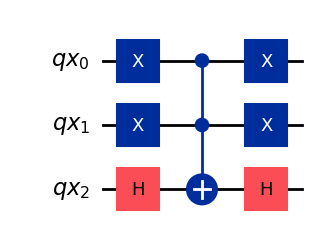

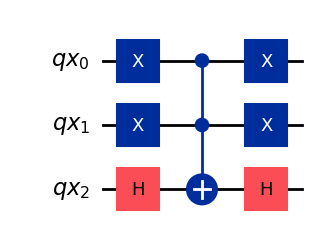

In [4]:
decomp_oracle = oracle.decompose('mcmt', reps=2)
decomp_oracle.draw('mpl')

In [5]:
oracle_gate = decomp_oracle.to_gate()

Creamos un circuito cuántico de esos n qubits.

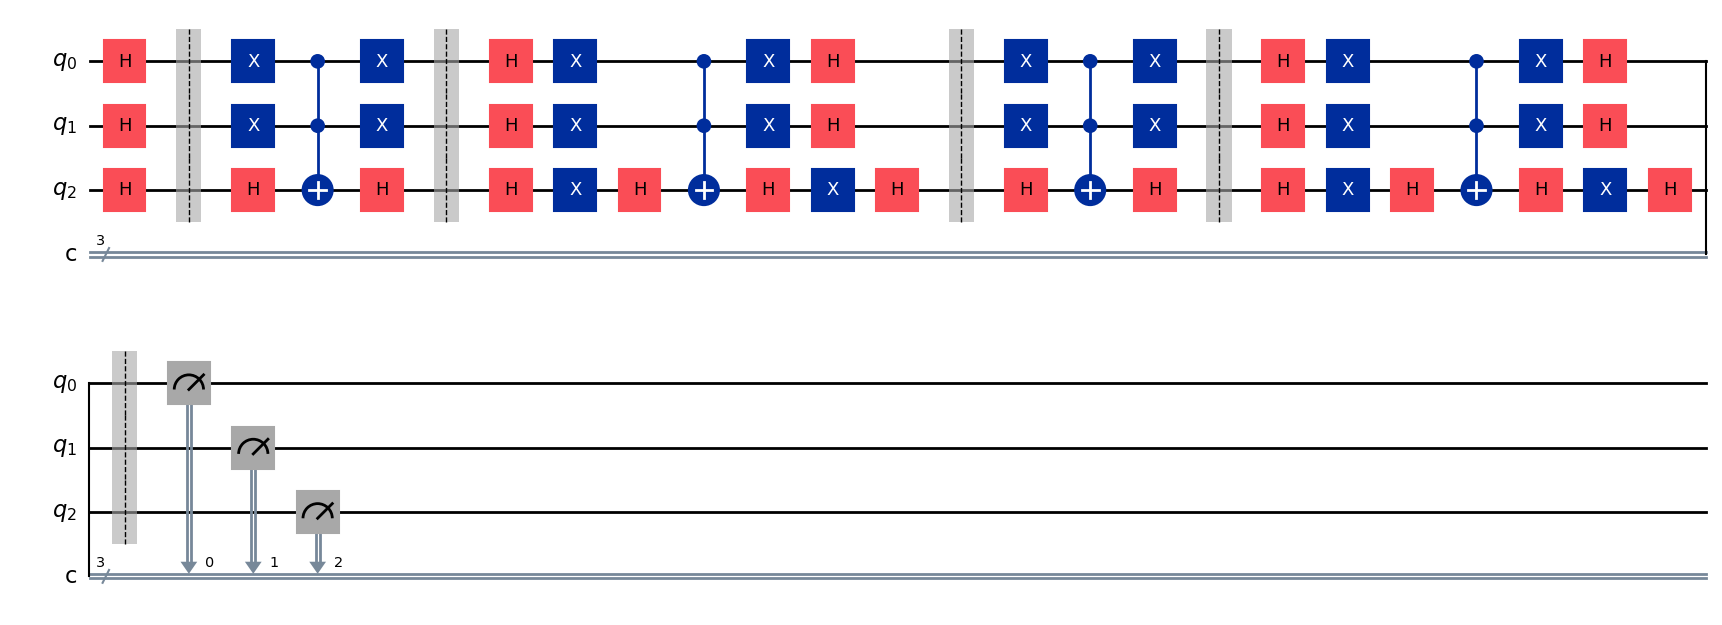

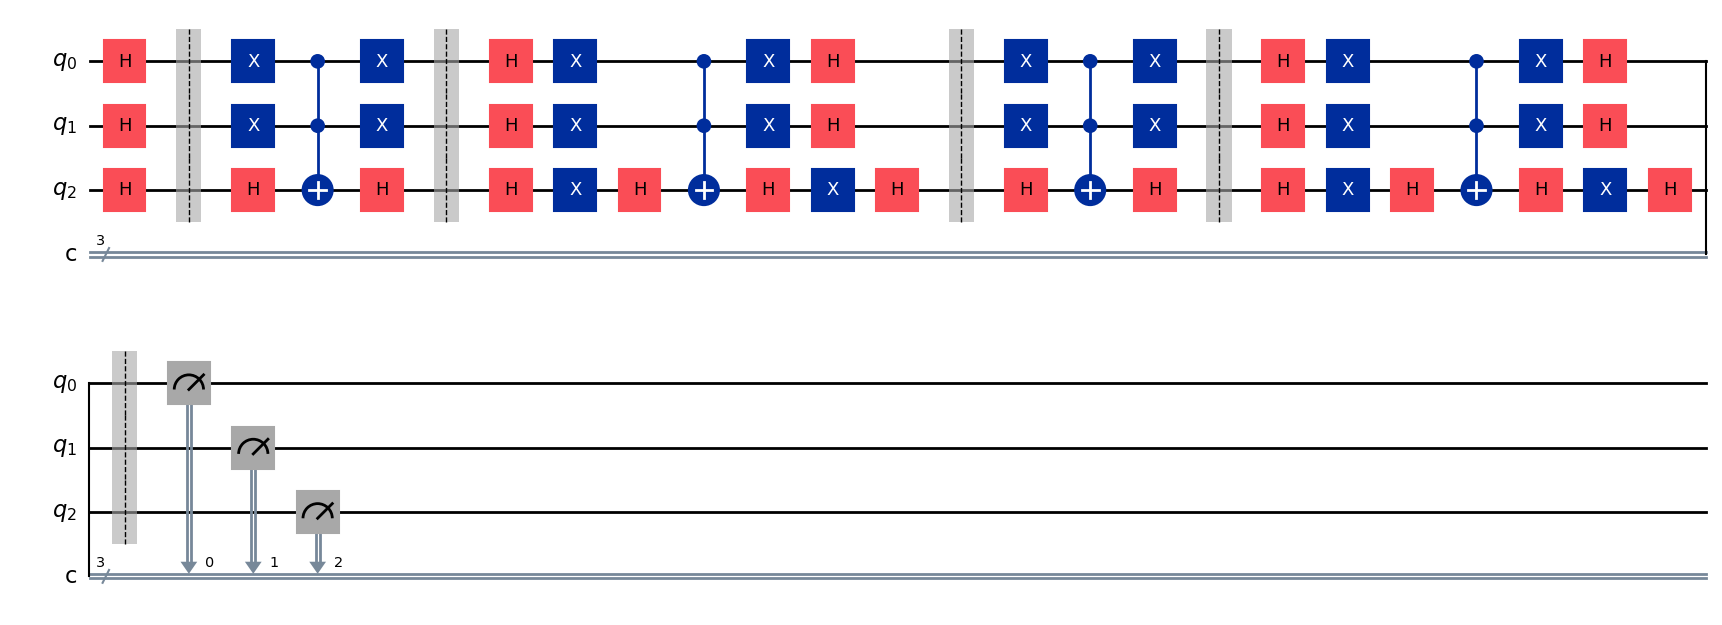

In [6]:
qc = Grover_Circuit(n, oracle_gate)

qc.draw('mpl')

---
# Ejecutando el circuito

Vamos a comprobar si obtenemos el resultado esperado. Deberíamos obtener el 100.

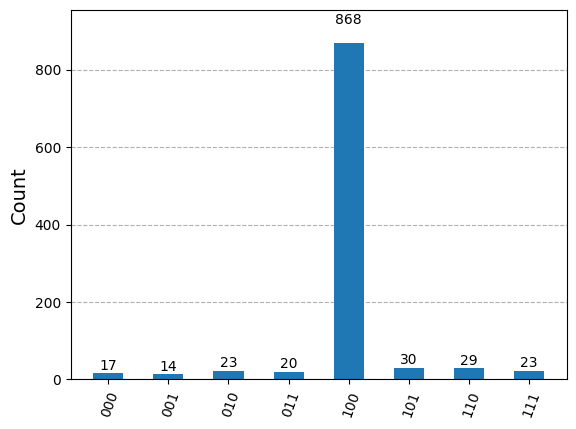

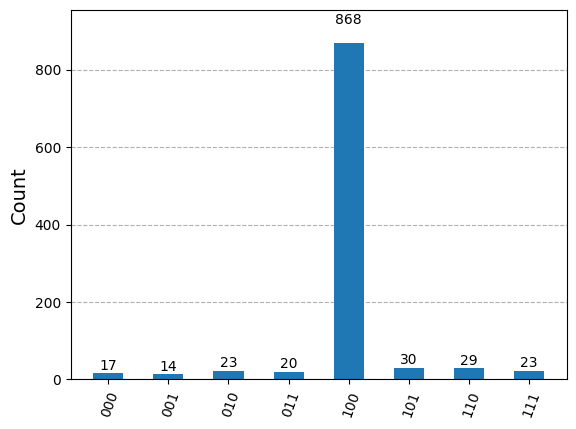

In [7]:
#Obtenemos el simulador de n qubits
backend = GenericBackendV2(num_qubits=n)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Obtenemos que todas las medidas son para el 100, por lo que es balanceada, como esperábamos.

Importante: fijaos en que los bits están al revés de cómo podríamos pensar al ver los circuitos. Si queréis que se vea como lo solemos pensar, llega con poner measure(range(n), range(n-1,-1,-1)) para que asigne al revés.

---
# Ejercicio con otro oráculo

Ahora haz un oráculo que marque otro estado y pruébalo.

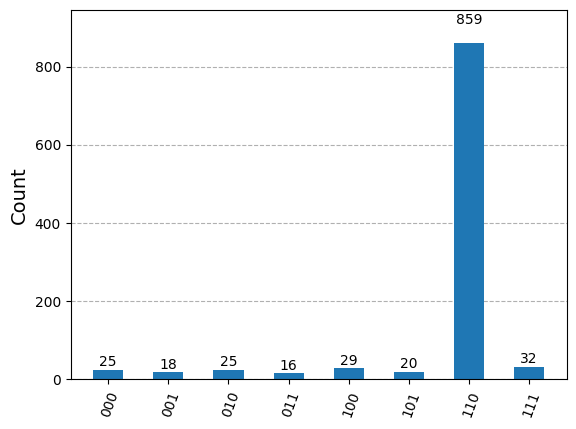

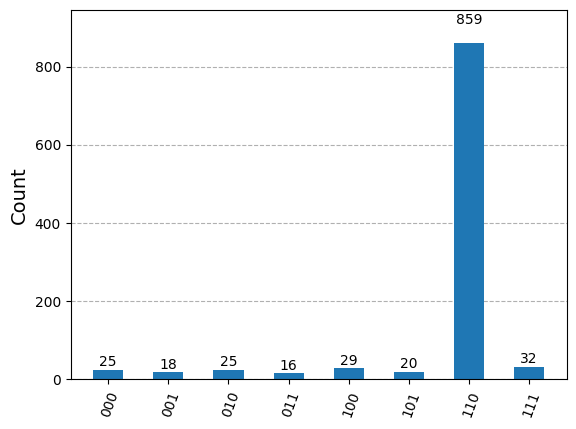

In [8]:
n = 3

#Registros
qr_x = QuantumRegister(n, 'qx')

oracle = QuantumCircuit(qr_x, name='Oracle')

#Puertas
multicontrolz = MCMT(ZGate(), n-1, 1)
oracle.x(0)
oracle.append(multicontrolz, range(n))
oracle.x(0)

decomp_oracle = oracle.decompose('mcmt', reps=2)
oracle_gate = decomp_oracle.to_gate()

qc = Grover_Circuit(n, oracle_gate)

#Obtenemos el simulador de n qubits
backend = GenericBackendV2(num_qubits=n)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

---
# Ejercicio extra

Prueba a hacer un oráculo que marque más de un estado. En este caso, ten en cuenta que si se marcan t soluciones, hay que aplicar $\frac{\pi}{4}\sqrt{\frac{N}{t}}$ repeticiones. Deberás cambiar la función global.

In [9]:
def Grover_Circuit(n:int, oracle, t:int=1):
    #Registros
    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(n, 'c')

    #Circuito
    qc = QuantumCircuit(qr, cr, name='Grover')

    #Capa de H
    qc.h(range(n))
    qc.barrier()

    n_reps = int(np.pi/4*np.sqrt(2**n / t))
    #Control-Z con varios ctrl
    multicontrolz = MCMT(ZGate(), n-1, 1)
    for i in range(n_reps):
        #Oraculo
        qc.append(oracle, range(n))
        qc.barrier()

        #Difusor
        qc.h(range(n))
        qc.x(range(n))
        qc.append(multicontrolz, range(n))
        qc.x(range(n))
        qc.h(range(n))
        qc.barrier()

    #Mediciones
    qc.measure(range(n), range(n))

    decomp_qc = qc.decompose(['mcmt', 'Oracle'], reps=2)

    return decomp_qc

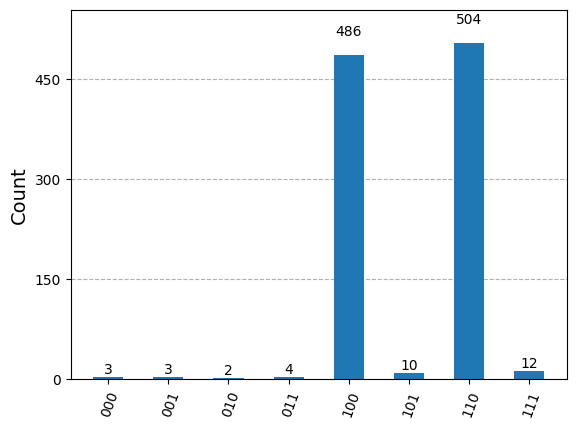

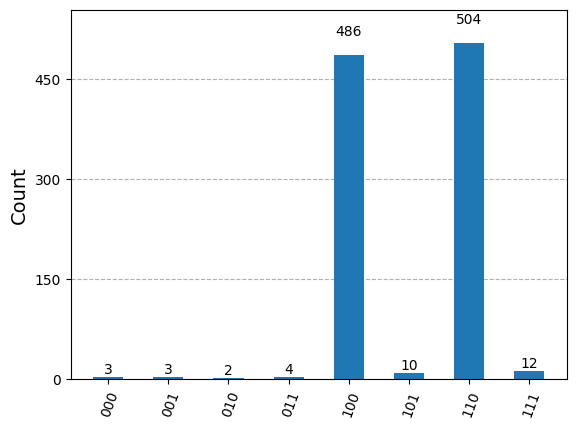

In [10]:
n = 3

#Registros
qr_x = QuantumRegister(n, 'qx')

oracle = QuantumCircuit(qr_x, name='Oracle')

#Puertas
multicontrolz = MCMT(ZGate(), n-2, 1)
oracle.x(0)
oracle.append(multicontrolz, [0,2])
oracle.x(0)

decomp_oracle = oracle.decompose('mcmt', reps=2)
oracle_gate = decomp_oracle.to_gate()

qc = Grover_Circuit(n, oracle_gate,t=2)

#Obtenemos el simulador de n qubits
backend = GenericBackendV2(num_qubits=n)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)